# Check-in 6: Neural Network

In [5]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm

In [6]:
# load the dataset
df = pd.read_csv("hf://datasets/maharshipandya/spotify-tracks-dataset/dataset.csv")

In [7]:
# remove all rows with missing values
df.dropna(inplace=True) 

# remove all duplicate values based on track name and artist name
df.drop_duplicates(subset=['track_name', 'artists'], inplace=True)

In [ ]:
genres = ['acoustic' 'afrobeat' 'alt-rock' 'alternative' 'ambient' 'anime'
    'black-metal' 'bluegrass' 'blues' 'brazil' 'breakbeat' 'british'
    'cantopop' 'chicago-house' 'children' 'chill' 'classical' 'club' 'comedy'
    'country' 'dance' 'dancehall' 'death-metal' 'deep-house' 'detroit-techno'
    'disco' 'disney' 'drum-and-bass' 'dub' 'dubstep' 'edm' 'electro'
    'electronic' 'emo' 'folk' 'forro' 'french' 'funk' 'garage' 'german'
    'gospel' 'goth' 'grindcore' 'groove' 'grunge' 'guitar' 'happy'
    'hard-rock' 'hardcore' 'hardstyle' 'heavy-metal' 'hip-hop' 'honky-tonk'
    'house' 'idm' 'indian' 'indie-pop' 'indie' 'industrial' 'iranian'
    'j-dance' 'j-idol' 'j-pop' 'j-rock' 'jazz' 'k-pop' 'kids' 'latin'
    'latino' 'malay' 'mandopop' 'metal' 'metalcore' 'minimal-techno' 'mpb'
    'new-age' 'opera' 'pagode' 'party' 'piano' 'pop-film' 'pop' 'power-pop'
    'progressive-house' 'psych-rock' 'punk-rock' 'punk' 'r-n-b' 'reggae'
    'reggaeton' 'rock-n-roll' 'rock' 'rockabilly' 'romance' 'sad' 'salsa'
    'samba' 'sertanejo' 'show-tunes' 'singer-songwriter' 'ska' 'sleep'
    'songwriter' 'soul' 'spanish' 'study' 'swedish' 'synth-pop' 'tango'
    'techno' 'trance' 'trip-hop' 'turkish' 'world-music'
 ]

genre_mapping = {
    "rock_alt_metal": [
        "alt-rock", "alternative", "black-metal", "death-metal", "emo", "goth",
        "grindcore", "grunge", "hard-rock", "hardcore", "heavy-metal", "metal",
        "metalcore", "psych-rock", "punk-rock", "punk", "rock", "rock-n-roll", "hardstyle", "j-rock", "rockabilly"
    ],
    "pop_indie": [
        "pop", "power-pop", "pop-film", "indie", "indie-pop", "j-pop", "k-pop",
        "cantopop", "mandopop", "synth-pop"
    ],
    "electronic_dance": [
        "edm", "dance", "electro", "electronic", "trance", "techno",
        "detroit-techno", "chicago-house", "progressive-house", "deep-house",
        "house", "minimal-techno", "dubstep", "drum-and-bass", "breakbeat",
        "dub", "idm", "disco", "garage", "groove"
    ],
    "hiphop_rnb": [
        "hip-hop", "r-n-b", "soul", "funk"
    ],
    "jazz_classical": [
        "jazz", "blues", "classical", "piano"
    ],
    "country_folk": [
        "country", "folk", "bluegrass", "honky-tonk", "singer-songwriter",
        "songwriter", "acoustic"
    ],
    "latin_world": [
        "latin", "latino", "afrobeat", "brazil", "mpb", "samba", "salsa", "tango",
        "pagode", "forro", "sertanejo", "reggaeton", "indian", "iranian",
        "turkish", "french", "german", "british", "swedish", "malay", "world-music"
    ],
    "reggae": [
        "reggae", "dancehall"
    ],
    "ambient_chill": [
        "ambient", "chill", "new-age", "trip-hop"
    ],
    "thematic": [
        "anime", "children", "comedy", "club", "disney", "gospel", "guitar",
        "happy", "industrial", "j-dance", "j-idol", "kids", "opera", "party",
        "romance", "sad", "show-tunes", "ska", "sleep", "spanish", "study"
    ]
}


flattened_mapping = {genre: category for category, subgenres in genre_mapping.items() for genre in subgenres}

# create a dictionary with keys being genres and the values being each genre
genres = [genre for genre, _ in genre_mapping.items()]
genre_encoding = {genre: i for i, genre in enumerate(genres)}

print(genre_encoding)

df['track_genre'] = df['track_genre'].apply(lambda x: flattened_mapping[x])


# genre_encoded
df_encoded = df
df_encoded['track_genre'] = df_encoded['track_genre'].apply(lambda x: genre_encoding[x])

# shuffle the dataframe
df_encoded = df_encoded.sample(frac=1).reset_index(drop=True)

# separate the features and the target variable (track_genre) and convert to tensors
X = torch.tensor(df_encoded.drop(columns=['track_genre']).select_dtypes(include=[np.number]).to_numpy(), dtype=torch.float32)
y = torch.tensor(df_encoded['track_genre'].to_numpy(), dtype=torch.long)

print(X.shape, y.shape)



{'rock_alt_metal': 0, 'pop_indie': 1, 'electronic_dance': 2, 'hiphop_rnb': 3, 'jazz_classical': 4, 'country_folk': 5, 'latin_world': 6, 'reggae': 7, 'ambient_chill': 8, 'thematic': 9}
torch.Size([81343, 15]) torch.Size([81343])


### create dataset, split

https://pytorch.org/tutorials/beginner/basics/data_tutorial.html?highlight=dataloader

In [9]:
class Track_dataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [10]:
# split the dataset into train, valid, and test sets
train_size = int(0.7 * len(df))
valid_size = int(0.15 * len(df))
test_size = len(df) - train_size - valid_size
X_train, X_valid, X_test = torch.split(X, [train_size, valid_size, test_size])
print(X_train.shape, X_valid.shape, X_test.shape)
y_train, y_valid, y_test = torch.split(y, [train_size, valid_size, test_size])
print(y_train.shape, y_valid.shape, y_test.shape)


train_dataset = Track_dataset(X_train, y_train)
valid_dataset = Track_dataset(X_valid, y_valid)
test_dataset = Track_dataset(X_test, y_test)

torch.Size([56940, 15]) torch.Size([12201, 15]) torch.Size([12202, 15])
torch.Size([56940]) torch.Size([12201]) torch.Size([12202])


### define model

In [11]:
# 3-layer neural network
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.fc1 = nn.Linear(15, 16)
        self.fc2 = nn.Linear(16, 32)
        self.fc3 = nn.Linear(32, 10)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

### train the model

In [21]:
model = Model()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

# create dataloaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# train the model, record the validation loss for the plots
n_epochs = 50
train_loss_hist, valid_loss_hist = [], []
for epoch in range(n_epochs):
    tot_train_loss, tot_valid_loss = 0, 0

    model.train()
    for x, y in tqdm(train_loader):
        optimizer.zero_grad()
        y_pred = model(x)
        loss = criterion(y_pred, y)
        tot_train_loss += loss.item()
        loss.backward()
        optimizer.step()
    
    model.eval()
    with torch.no_grad():
        tot_valid_loss = 0
        for x, y in valid_loader:
            y_pred = model(x)
            valid_loss = criterion(y_pred, y)
            tot_valid_loss += valid_loss.item()
        print(f"Epoch {epoch}: Validation Loss: {tot_valid_loss/len(valid_loader)}")
    train_loss_hist.append(tot_train_loss/len(train_loader))
    valid_loss_hist.append(tot_valid_loss/len(valid_loader))

100%|██████████| 890/890 [00:00<00:00, 1328.07it/s]


Epoch 0: Validation Loss: 16.68322064364768


100%|██████████| 890/890 [00:00<00:00, 1463.93it/s]


Epoch 1: Validation Loss: 13.155196214845667


100%|██████████| 890/890 [00:00<00:00, 1433.70it/s]


Epoch 2: Validation Loss: 18.65353476439471


100%|██████████| 890/890 [00:00<00:00, 1369.64it/s]


Epoch 3: Validation Loss: 21.28140261784898


100%|██████████| 890/890 [00:00<00:00, 1160.69it/s]


Epoch 4: Validation Loss: 16.77072193984586


100%|██████████| 890/890 [00:00<00:00, 1320.44it/s]


Epoch 5: Validation Loss: 15.36115897263532


100%|██████████| 890/890 [00:00<00:00, 1416.35it/s]


Epoch 6: Validation Loss: 11.063380288828105


100%|██████████| 890/890 [00:00<00:00, 1452.58it/s]


Epoch 7: Validation Loss: 15.353799914814415


100%|██████████| 890/890 [00:00<00:00, 1430.51it/s]


Epoch 8: Validation Loss: 16.451192541272228


100%|██████████| 890/890 [00:00<00:00, 1471.35it/s]


Epoch 9: Validation Loss: 13.213081604523184


100%|██████████| 890/890 [00:00<00:00, 1293.48it/s]


Epoch 10: Validation Loss: 17.416178413710668


100%|██████████| 890/890 [00:00<00:00, 1444.02it/s]


Epoch 11: Validation Loss: 15.277475392007078


100%|██████████| 890/890 [00:00<00:00, 1435.91it/s]


Epoch 12: Validation Loss: 10.82008270693075


100%|██████████| 890/890 [00:00<00:00, 1418.24it/s]


Epoch 13: Validation Loss: 8.61537424057566


100%|██████████| 890/890 [00:00<00:00, 1400.21it/s]


Epoch 14: Validation Loss: 9.084565866680045


100%|██████████| 890/890 [00:00<00:00, 1463.50it/s]


Epoch 15: Validation Loss: 13.285620464704424


100%|██████████| 890/890 [00:00<00:00, 1478.50it/s]


Epoch 16: Validation Loss: 10.292391989243592


100%|██████████| 890/890 [00:00<00:00, 1444.54it/s]


Epoch 17: Validation Loss: 8.66604450485469


100%|██████████| 890/890 [00:00<00:00, 1440.68it/s]


Epoch 18: Validation Loss: 8.620262415621292


100%|██████████| 890/890 [00:00<00:00, 1343.06it/s]


Epoch 19: Validation Loss: 5.119393877958128


100%|██████████| 890/890 [00:00<00:00, 1450.70it/s]


Epoch 20: Validation Loss: 6.574068274173437


100%|██████████| 890/890 [00:00<00:00, 1471.91it/s]


Epoch 21: Validation Loss: 10.515776441983528


100%|██████████| 890/890 [00:00<00:00, 1457.63it/s]


Epoch 22: Validation Loss: 4.402412432026488


100%|██████████| 890/890 [00:00<00:00, 1445.52it/s]


Epoch 23: Validation Loss: 6.930796061510815


100%|██████████| 890/890 [00:00<00:00, 1323.45it/s]


Epoch 24: Validation Loss: 6.237387147873484


100%|██████████| 890/890 [00:00<00:00, 1199.02it/s]


Epoch 25: Validation Loss: 4.866093156225395


100%|██████████| 890/890 [00:00<00:00, 1393.06it/s]


Epoch 26: Validation Loss: 7.804406320861497


100%|██████████| 890/890 [00:00<00:00, 1411.82it/s]


Epoch 27: Validation Loss: 4.878023900286689


100%|██████████| 890/890 [00:00<00:00, 1461.52it/s]


Epoch 28: Validation Loss: 3.6575618464285164


100%|██████████| 890/890 [00:00<00:00, 1221.25it/s]


Epoch 29: Validation Loss: 4.789689339892402


100%|██████████| 890/890 [00:00<00:00, 1240.30it/s]


Epoch 30: Validation Loss: 5.661418899815744


100%|██████████| 890/890 [00:00<00:00, 1422.46it/s]


Epoch 31: Validation Loss: 2.673831070280824


100%|██████████| 890/890 [00:00<00:00, 1374.01it/s]


Epoch 32: Validation Loss: 2.6778143950157767


100%|██████████| 890/890 [00:00<00:00, 1462.36it/s]


Epoch 33: Validation Loss: 2.0964049163289094


100%|██████████| 890/890 [00:00<00:00, 1421.12it/s]


Epoch 34: Validation Loss: 2.085078451645936


100%|██████████| 890/890 [00:00<00:00, 1448.93it/s]


Epoch 35: Validation Loss: 2.007696900692286


100%|██████████| 890/890 [00:00<00:00, 1302.09it/s]


Epoch 36: Validation Loss: 1.8878027587660944


100%|██████████| 890/890 [00:00<00:00, 1474.03it/s]


Epoch 37: Validation Loss: 1.9238599020773204


100%|██████████| 890/890 [00:00<00:00, 1406.93it/s]


Epoch 38: Validation Loss: 1.92821403885387


100%|██████████| 890/890 [00:00<00:00, 1469.01it/s]


Epoch 39: Validation Loss: 2.026011612402831


100%|██████████| 890/890 [00:00<00:00, 1300.77it/s]


Epoch 40: Validation Loss: 1.9189298658470832


100%|██████████| 890/890 [00:00<00:00, 1457.60it/s]


Epoch 41: Validation Loss: 2.0545398021867762


100%|██████████| 890/890 [00:00<00:00, 1482.38it/s]


Epoch 42: Validation Loss: 1.889877269405345


100%|██████████| 890/890 [00:00<00:00, 1455.57it/s]


Epoch 43: Validation Loss: 1.9135279106220027


100%|██████████| 890/890 [00:00<00:00, 1429.50it/s]


Epoch 44: Validation Loss: 1.9135102832504591


100%|██████████| 890/890 [00:00<00:00, 1386.63it/s]


Epoch 45: Validation Loss: 1.9298122815436718


100%|██████████| 890/890 [00:00<00:00, 1460.32it/s]


Epoch 46: Validation Loss: 2.002804807343408


100%|██████████| 890/890 [00:00<00:00, 1354.20it/s]


Epoch 47: Validation Loss: 1.9160755679245394


100%|██████████| 890/890 [00:00<00:00, 1432.32it/s]


Epoch 48: Validation Loss: 1.9174464460442828


100%|██████████| 890/890 [00:00<00:00, 1340.24it/s]


Epoch 49: Validation Loss: 1.8516788707353682


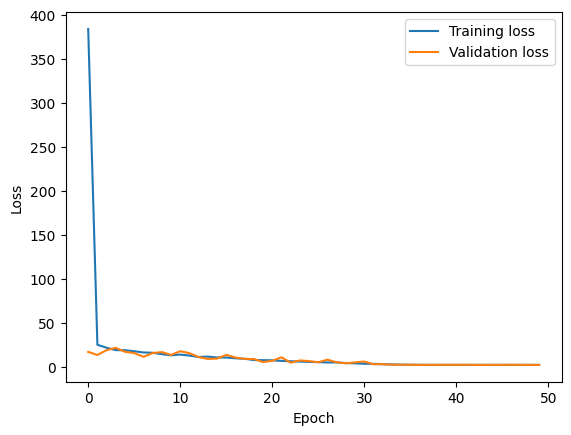

In [22]:
# plot the training and validation loss
import matplotlib.pyplot as plt
plt.plot(train_loss_hist, label='Training loss')
plt.plot(valid_loss_hist, label='Validation loss')
# set the x-axis to be in terms of epochs
plt.xlabel('Epoch')
plt.ylabel('Loss')
# set the y-axis max to 400
plt.legend()
plt.show()

In [23]:
# test the model
model.eval()
with torch.no_grad():
    test_loss = 0
    correct = 0
    total = 0
    for x, y in test_loader:
        y_pred = model(x)
        test_loss += criterion(y_pred, y)
        predicted = torch.argmax(y_pred, 1)
        total += y.size(0)
        correct += (predicted == y).sum().item()
    print(f"Test Loss: {test_loss.item()/len(test_loader)}")
    print(f"Test Accuracy: {correct / total}")

Test Loss: 1.8458873489140215
Test Accuracy: 0.3057695459760695
